In [1]:
!pip install tensorflow

In [16]:
!pip install gradio


In [6]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


In [18]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [31]:
import zipfile
import os

zip_ref = zipfile.ZipFile("archive (1).zip", 'r')
zip_ref.extractall("/content/TrashType_Image_Dataset")
zip_ref.close()


In [53]:
import os

path = "/content/TrashType_Image_Dataset/TrashType_Image_Dataset/"
print(os.listdir(path))


['metal', 'cardboard', 'paper', 'glass', 'plastic', 'trash']


In [54]:
dataset_path = "/content/TrashType_Image_Dataset/TrashType_Image_Dataset/"


In [82]:
# When creating the datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    shuffle=False,
    image_size=(128, 128),
    batch_size=32
)

# ✅ Save class names here
class_names = train_ds.class_names


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Found 2527 files belonging to 6 classes.


In [62]:
class_names = train_ds.class_names
print("Classes:", class_names)
print("Number of classes:", len(class_names))


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of classes: 6


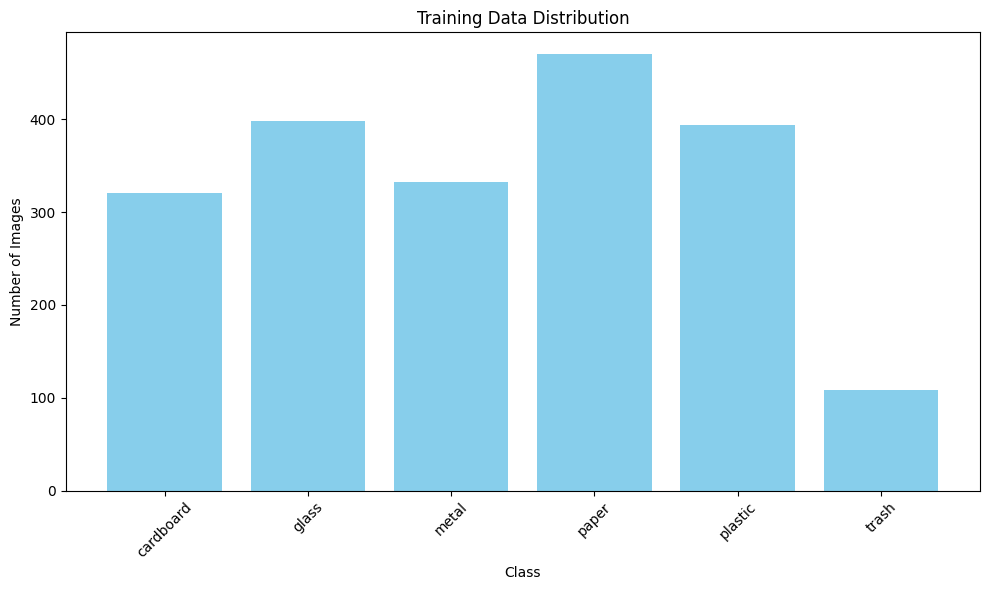

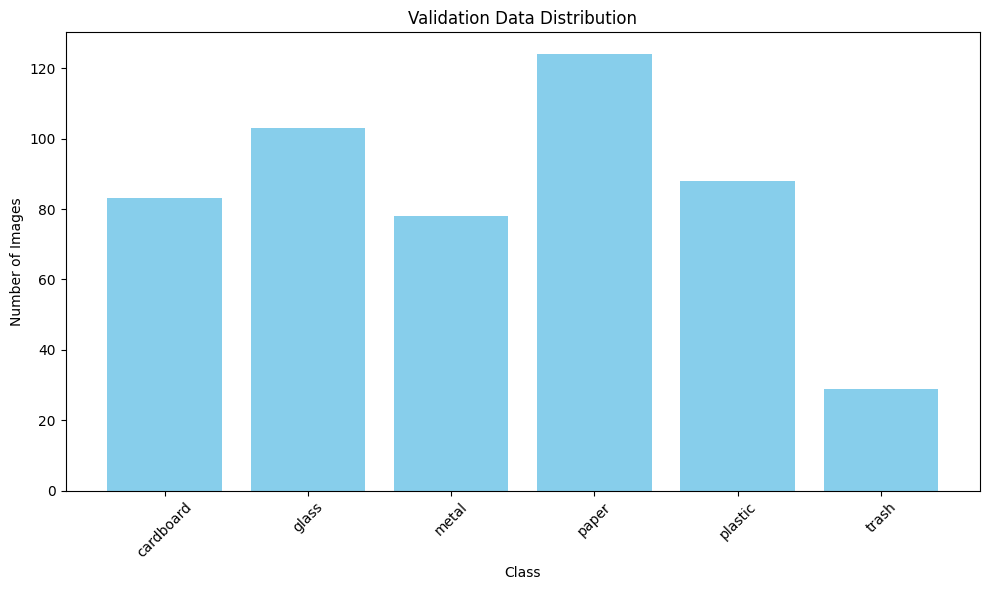

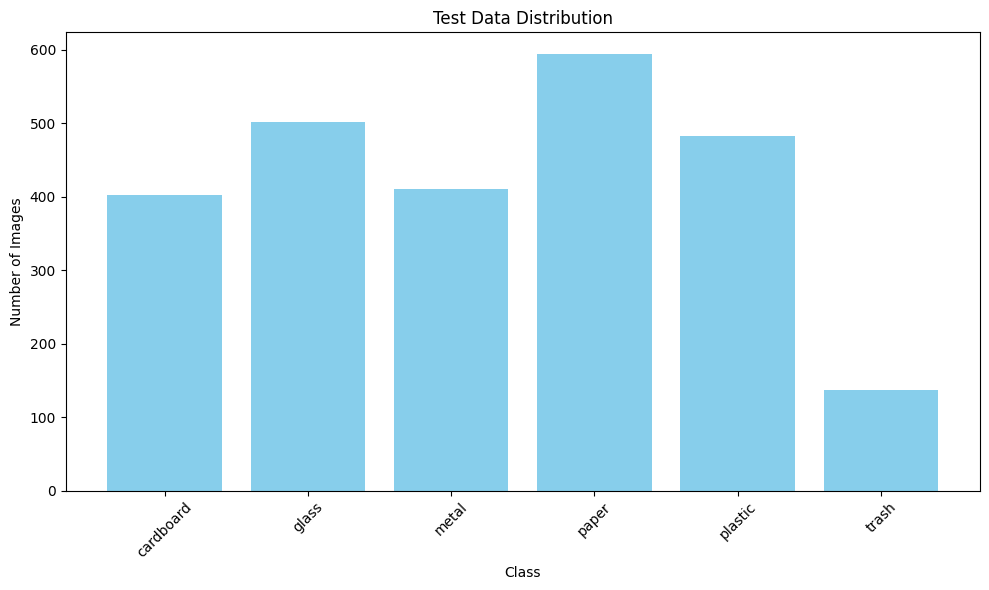

In [83]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(dataset, class_names, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        class_names: List of class names
        title: Title for the plot (e.g., 'Train Data Distribution')
    """
    class_counts = dict.fromkeys(class_names, 0)

    # Iterate through batches and count labels
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            class_counts[class_name] += 1

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Assuming these are your loaded datasets
# Make sure you've already run these before:

# datatrain = ...
# datavalid = ...
# datatest = ...
# class_names = datatrain.class_names

# Now plot the distributions
plot_class_distribution(train_ds, class_names, "Training Data Distribution")
plot_class_distribution(val_ds, class_names, "Validation Data Distribution")
plot_class_distribution(test_ds, class_names, "Test Data Distribution")



**DATA AUGMENTATION AND NORMALIZATION**

---




In [63]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

preprocess = tf.keras.applications.efficientnet.preprocess_input
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)


**BUILD THE MODEL**

---



In [64]:
base_model = EfficientNetV2B0(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = False  # Freeze for faster training

model = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,926,998 (22.61 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [69]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ input_layer_9[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 128, 128,  │          0 │ rescaling_3[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

**TRAIN THE MODEL**

---



In [65]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 71s 857ms/step - accuracy: 0.2075 - loss: 1.8771 - val_accuracy: 0.3941 - val_loss: 1.5803
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 774ms/step - accuracy: 0.3661 - loss: 1.5948 - val_accuracy: 0.5545 - val_loss: 1.3626
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 729ms/step - accuracy: 0.4935 - loss: 1.3927 - val_accuracy: 0.6416 - val_loss: 1.2058
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 781ms/step - accuracy: 0.5365 - loss: 1.2894 - val_accuracy: 0.6911 - val_loss: 1.0915
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 767ms/step - accuracy: 0.5939 - loss: 1.1782 - val_accuracy: 0.7089 - val_loss: 1.0040
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 765ms/step - accuracy: 0.6547 - loss: 1.0715 - val_accuracy: 0.7366 - val_loss: 0.9350
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 744ms/step - accuracy: 0.6525 - loss: 1.0356 - val_accuracy: 0.7426 - val_loss: 0.8785
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 771ms/step - accuracy: 0.6910 - loss: 0.9465 - val_accu

In [66]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 501ms/step - accuracy: 0.8372 - loss: 0.5243
Test Accuracy: 0.8013454675674438


**PLOT ACCURACY AND LOSS GRAPHS**

---



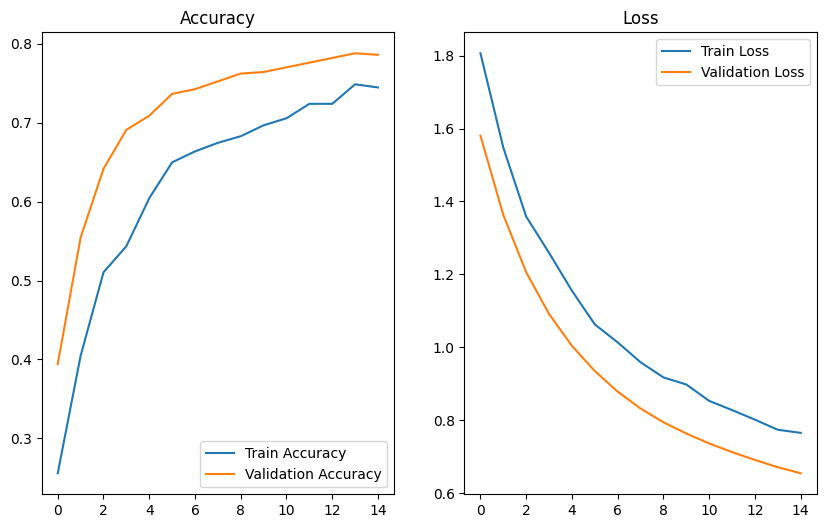

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()


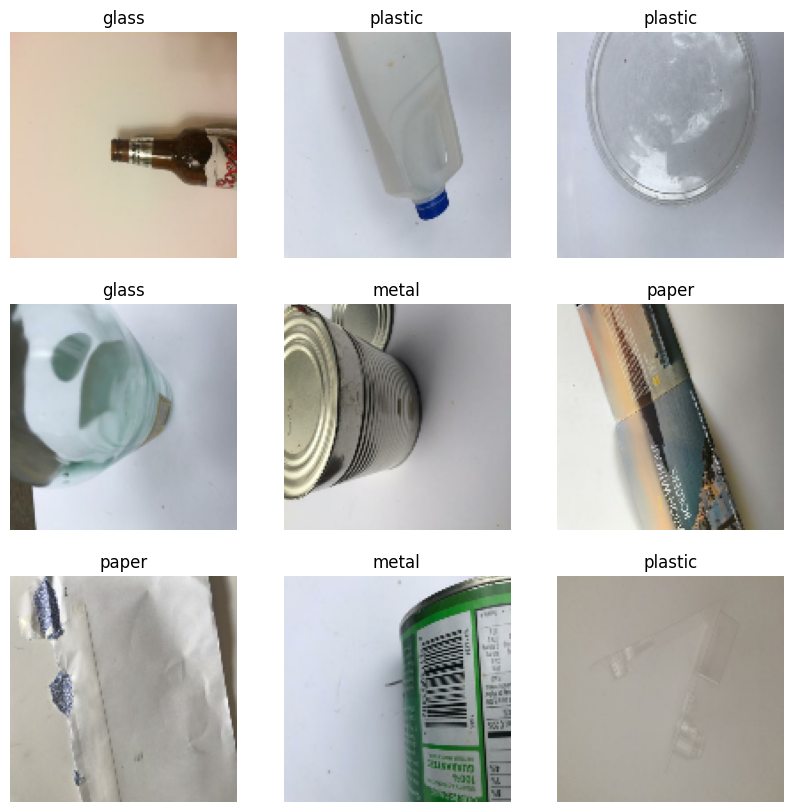

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
